The model built here is using fastai library's implemetation of ULMFIT which is pre-training language model for Natural Language Processing tasks. The layout of this notebook is as followed

* Importing necessary libraries
* Data preparation for the model
* Pre-training of the language model
* Training the multi-class classification model

Dependencies are:
* fastai v1
* pytorch
* numpy
* pandas
* matplotlib
* sklearn
* seaborn

# Importing necessary libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
from fastai import *
from fastai.text import *
import pandas as pd
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

# Data Preparation for the model

In [7]:
#read in the data file
df=pd.read_csv('Safety_GPS1.csv')
#need to have the free text and the category 
col_to_keep=['INCIDENT TITLE','DESCRIPTION','CATEGORY']
reports=df[col_to_keep]
#drop those columns without descriptions
reports=reports.dropna()
#now focus on a few single categories
categories_focus={'Touching /Groping, ':0,'Touching /Groping, Others, ':0,'Stalking, ':1,'Sexual Invites, ':2,'Commenting, ':3,'Rape / Sexual Assault, ':4,
                  'Sexual Invites, North East India Report, ':2,'Chain Snatching, ':5,'Chain Snatching, Others, ':5,
                  'Ogling/Facial Expressions/Staring, ':6,'Indecent exposure, ':7,'Taking pictures, ':8,'Taking pictures, Others, ':8,
                  'Sexual Invites, Others, ':2,'Catcalls/Whistles, North East India Report, ':9}
label=[]
index_keep=[]
for index,row in reports.iterrows():
    if row['CATEGORY'] in categories_focus:
        label.append(categories_focus[row['CATEGORY']])
        index_keep.append(index)

#select the reports with selected categories 
reports_sub=reports.loc[index_keep]


In [ ]:
#here we count up the labels to get a sense of balance in the dataset and indeed the dataset is imbalanced with only 2
#incidences in category 9
label_count={}
for item in label:
    try:
        label_count[item]+=1
    except KeyError:
        label_count[item]=1
label_count

In [ ]:
#preprocess the description: turn all into lower case and remove extra spaces
list_of_reports=reports_sub['DESCRIPTION'].values.tolist()

def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)
def text_cleaning(texts):
    import re
    #lower case all the text messages:
    texts=[message.lower() for message in texts]
    
    #remove extra spaces
    texts=[re.sub(r"\s+"," ", message) for message in texts]
    
    #remove repeated letters in words
    texts=[reduce_lengthening(message) for message in texts]
    
    #remove punctuation marks
    texts=[re.sub(r'[^\w\s]','',message) for message in texts]
    
    return texts

report_clean=text_cleaning(list_of_reports)

In [ ]:
#format into dataframe and split for training and evaluation set
text=pd.DataFrame({'Label':label,'Text':report_clean})
#split it into train and val randomly
np.random.seed(0)
msk = np.random.rand(len(text)) < 0.8
train = text[msk]
val = text[~msk]
train.to_pickle('train.pkl')
val.to_pickle('val.pkl')

# Pre-training of the language model

In [2]:
#set the batch size and cpu device for training the neural nets
path=''
bs=48
# bs=24
# bs=192
torch.cuda.set_device(0)

NameError: name 'torch' is not defined

In [121]:
train=pd.read_pickle('train.pkl')
val=pd.read_pickle('val.pkl')

In [123]:
# in fastai the data needs to be loaded into a Language Model Data Bunch object
data_lm=TextLMDataBunch.from_df(path='',train_df=train,valid_df=val)
data_lm.show_batch()

idx,text
0,y a boy in the school xxbos there are some boys who likes disturbing a girl when she in class even if she has been sent they follow him xxbos there is a teacher who likes touching a girl on the breast xxbos guy just started following me xxbos a girl is asking if a boy comes to your house so that they can do xxunk together xxbos i have
1,month day time are approximate xxbos a girl was walking home and a man tried to hold her by force xxbos 19th december 2017 around 1030 am in broad daylight at andheri station mumbai i had just gotten out of a train and was heading to the staircase to get to the xxunk xxunk there was a lot of crowd leading to a mini stampede situation i lost my sisters
2,to touch a girl on her private parts xxbos a boy likes disturbing girls in class when the teacher is not there xxbos there is a boy who like disturbing a girl in class xxbos there was a day that a man wanted to rape a girl when she was from school xxbos some boys tried to rape a girl but she screamed and was helped but they followed her
3,boys are catching girls on the breast xxbos a girl was going to fetch water from a local water vendor and met a boy on the road and asked her for help and she xxunk then asked for sex but she refused xxbos a girl was raped and her friend is asking for help xxbos a was asked by her her father to have sex with her xxbos a girl
4,interested in having sex with him xxbos he was passing by the corner of cafe xxunk an xxunk couple were fighting and in that xxunk the boy slapped the girl she was embarrassed and left the spot xxbos he was in 2nd year he was coming college from fc street at that time one girl was crying badly and one guy was beating her after some time boy went away


In [125]:
data_lm.save('lm_databunch')

In [126]:
data_lm = load_data(path, 'lm_databunch', bs=bs)

In [127]:
#initialise the learner for the language model which is pre-trained on Wikipedia texts in English
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [129]:
#Here we try to generate some sentences with the current language model
TEXT = "Someone is following me "
N_WORDS = 30
N_SENTENCES = 2
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Someone is following me  on the screen is a people being in the studio together with i in Uncle John as a child and i know about my own life and i
Someone is following me  on a motorcycle trip at Old Man House in West Point is the White House For Your Friends With


In [132]:
#fitting the model
learn_lm.fit_one_cycle(1, 1e-1)
learn_lm.save('fit_1')
learn_lm.load('fit_1')
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 1e-2)
learn_lm.save('fine_tuned')
learn_lm.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.528765,3.279781,0.314286,00:08


In [143]:
# let's try generating some sentences again after the language model training, hopefully this time the sentences will
# be a lot closer to the tone that we see in the reports from safecity
TEXT = "Someone is following me "
N_WORDS = 30
N_SENTENCES = 2
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Someone is following me  on the metro xxbos this happened to me in the morning while i was walking on the road xxbos a girl was grouped by some ill mannered guy and were
Someone is following me  when i was going to school for nothing and i have to ride him xxbos it was really bad xxbos some boys were passing through a girl who was passing


# Training the multi-class classification model

In [146]:
# fastai requires the texts to be casted into a classification data bunch object
data_clf=TextClasDataBunch.from_df(path='',train_df=train,valid_df=val)
data_clf.show_batch()

text,target
xxbos four or five recent xxunk of violence and abuse and the public reaction to them merit comment first it is xxunk how xxunk are being xxunk by many between language used inside the parliament and outside let me begin with xxunk condemning defence minister khwaja xxunk comment on opposition leader xxunk xxunk voice his xxunk request to make her voice xxunk and the use of the term truck xxunk,3
xxbos kami telah xxunk ke xxunk xxunk xxunk xxunk pada xxunk xxunk xxunk jam 3 lebih saya suami dan tiga anak xxunk kami khadijah hassan dan hamzah telah mengambil xxunk di xxunk meja makan di xxunk xxunk xxunk beberapa meja dan xxunk kami xxunk tiga orang lelaki xxunk xxunk sedang makan ketika suami saya mengambil xxunk saya terkejut melihat pandangan yang sangat mencurigakan xxunk lelaki xxunk orang ini berbaju biru,6
xxbos is this how women get harrassed by police in nepal or what happened to me today let me tell you what happened to me today i wanted to get some food while i was on my scooter putting the signal stopping and some seconds after all of the sudden somebody hit me on the scooter really hard with his bike luckily there were many people around but the driver,3
xxbos i was walking down the 15th main and just turned into the xxunk cross in xxunk xxunk sector 4 when i heard the sound of a scooter behind me so i moved to the left hand side of the road that particularly short stretch is a little dark as there are no houses on either side of the road and the trees are xxunk and xxunk xxunk hiding the,0
xxbos in the summer 2011 i stayed in xxunk ka xxunk as i had just returned from xxunk as a foreigner traveling xxunk would always stay in the guest houses here since the area felt safe one morning at 9 am as i prepared to leave the guesthouse to take a train to agra i was cornered by an ear cleaner it all happened very suddenly he offered to xxunk,0


In [147]:
#intialise the classification learner and load up the encoder that is pre-trained from the language model earlier
learn_c = text_classifier_learner(data_clf, AWD_LSTM, drop_mult=0.3)
learn_c.load_encoder('fine_tuned_enc')
#freeze all layers, we start the training from the last layer and work our ways back gradually
learn_c.freeze()

In [150]:
learn_c.fit_one_cycle(3, 1e-1)
learn_c.save('first')
learn_c.load('first')
#unfreeze the penultimate layer
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(5, slice(7e-2/(2.6**4),7e-2), moms=(0.8,0.7))
learn_c.save('2nd')
learn_c.load('2nd')
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(5, slice(5e-5/(2.6**4),5e-5), moms=(0.8,0.7))
learn_c.save('3rd')
learn_c.load('3rd')
learn_c.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,1.382436,1.192136,0.601504,00:09


In [ ]:
#here we might need to dump the unused tensors in case our RAM runs out
import gc
gc.collect()

In [165]:
learn_c.fit_one_cycle(3, slice(1e-6/(2.6**4),1e-6), moms=(0.8,0.7))
learn_c.save('clas')
#final accuracy is about 76%

epoch,train_loss,valid_loss,accuracy,time
0,0.175898,0.904576,0.758459,00:19
1,0.178906,0.887746,0.763158,00:20
2,0.170877,0.897094,0.760338,00:20


In [167]:
#try out a sample sentence to see if model has learned something 
learn_c.predict("a boy asked me to have sex with him on the street")
# 2 is sexual invite and this is indeed correct

(Category 2,
 tensor(2),
 tensor([1.4587e-04, 4.4581e-06, 9.9933e-01, 3.0914e-04, 1.1270e-04, 7.7849e-07,
         1.9954e-05, 2.1852e-05, 5.5088e-05, 1.7046e-07]))

In [168]:
# the classification uses attention mechanism and here we can visualise the word the model paid attention to
# the model paid most attention to ask and sex so indeed it has learned something
txt_ci = TextClassificationInterpretation.from_learner(learn_c)
test_text = "a boy asked me to have sex with him on the street"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [170]:
# this is the top 20 sentences that the model was most unsure of
txt_ci.show_top_losses(20)

Text,Prediction,Actual,Loss,Probability
xxbos i went to visit my sick friend in their house when i found five boys in the room i sat down and as i sat the boys closed the door and raped my friend and i,7,4,14.00,0.00
xxbos i saw an old man holding a class six pupil at xxunk,2,0,11.13,0.00
xxbos oglingfacial expressions,2,6,10.05,0.00
xxbos a while xxunk was travelling from kalyan station to the mall via a xxunk man around 40s was sitting next to me through the xxunk of travel he was trying to touch me inappropriately when i tried xxunk himhe put on a fight and started abusing me,2,0,9.25,0.00
xxbos a neighbour forcefully drugged a girl to his house locked her and sexually assaulted her,0,4,8.99,0.00
xxbos when i was going office i felt that some guys were knowingly touching my body parts,2,0,8.78,0.00
xxbos a neighbour sent a girl of age 12 to buy xxunk on her way back the man caught her hands and told her to go in the xxunk the girl shouted and the man left her she ran to a xxunk house and told the story as this story was catching xxunk this man disappeared,0,2,8.71,0.00
xxbos in night commenting,3,3,8.67,0.96
xxbos there is a girl who is who is being disturbed by a boy who and he even wants to touch her private parts she is only xxunk years and he even call her his wife,2,2,8.62,0.90
xxbos a man was teasing a young lady on the road,4,3,8.52,0.00


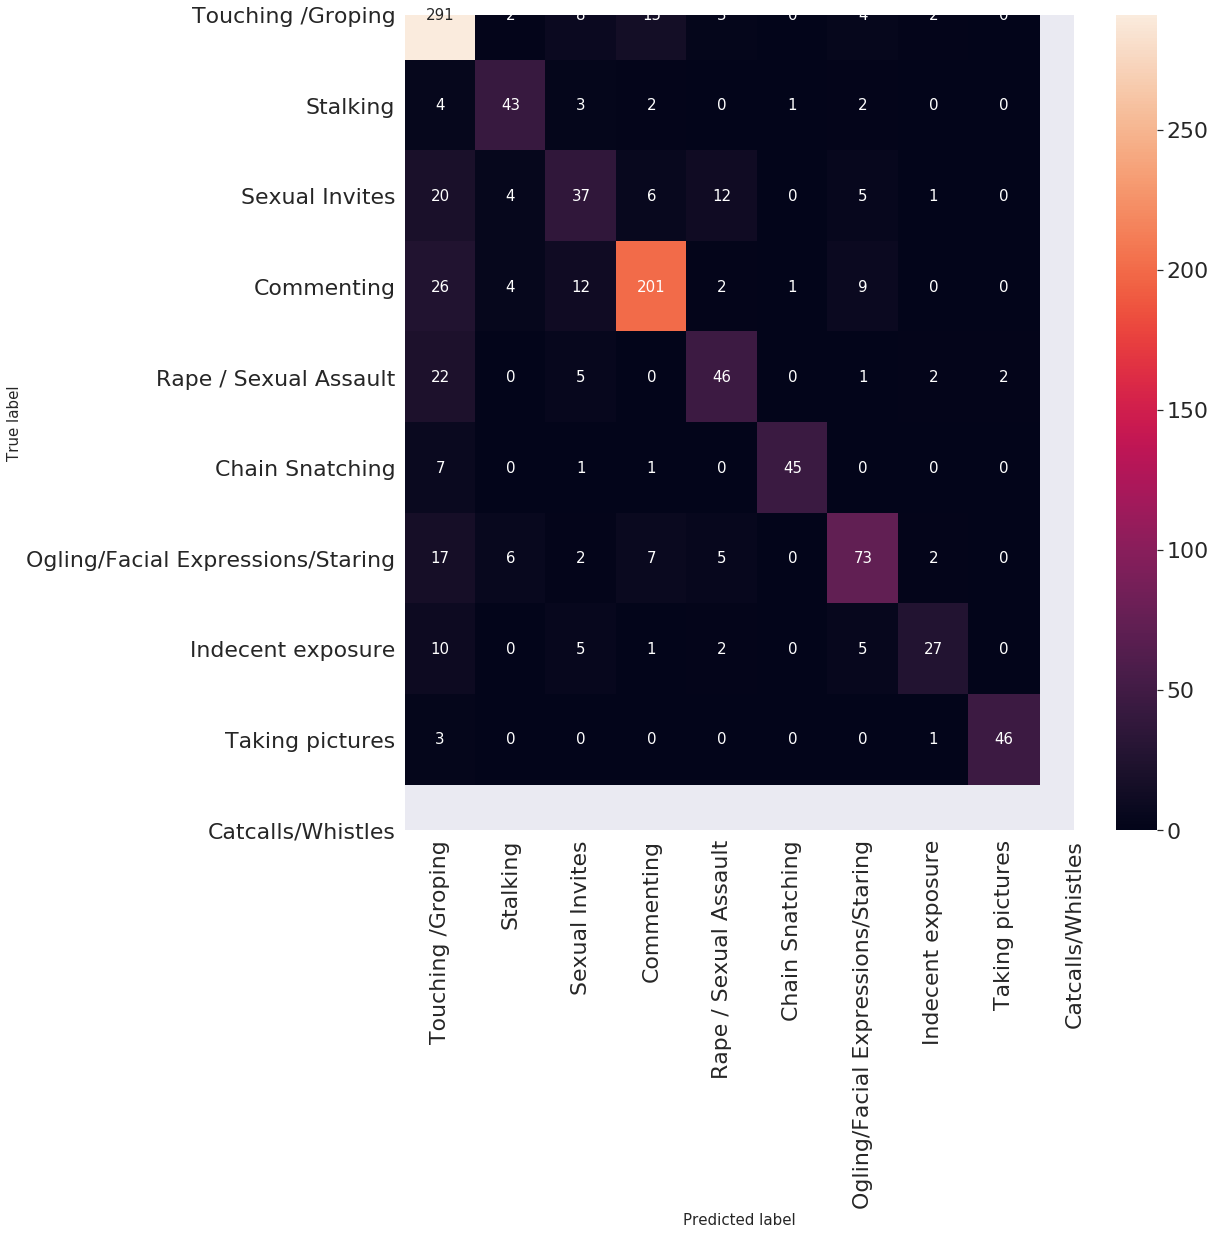

In [187]:
# get predictions and plot confusion matrix
preds, targets = learn_c.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

LABELS = ['Touching /Groping','Stalking','Sexual Invites','Commenting','Rape / Sexual Assault','Chain Snatching',
          'Ogling/Facial Expressions/Staring','Indecent exposure','Taking pictures','Catcalls/Whistles']

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 15});
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

In [ ]:
# can use the model for inference with a look up to the dictionary
categories_focus={'Touching /Groping, ':0,'Touching /Groping, Others, ':0,'Stalking, ':1,'Sexual Invites, ':2,'Commenting, ':3,'Rape / Sexual Assault, ':4,
                  'Sexual Invites, North East India Report, ':2,'Chain Snatching, ':5,'Chain Snatching, Others, ':5,
                  'Ogling/Facial Expressions/Staring, ':6,'Indecent exposure, ':7,'Taking pictures, ':8,'Taking pictures, Others, ':8,
                  'Sexual Invites, Others, ':2,'Catcalls/Whistles, North East India Report, ':9}
learn_c.predict('text input by the user')